Parse the raw event log to compare CPU and GPU hash aggregate operations.

In [37]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import HuberRegressor

# SF100
# cpu_profiles = "/opt/data/profiles/dataproc-cpu-sf100"
# gpu_profiles = "/opt/data/profiles/dataproc-gpu-sf100"
# cpu_events = "/opt/data/events/dataproc-cpu-sf100"
# gpu_events = "/opt/data/events/dataproc-gpu-sf100"

# SF3K
# cpu_profiles = "/opt/data/profiles/dataproc-cpu-sf3k"
# gpu_profiles = "/opt/data/profiles/dataproc-gpu-sf3k"
# cpu_events = "/opt/data/events/dataproc-cpu-sf3k"
# gpu_events = "/opt/data/events/dataproc-gpu-sf3k"

# SF5K
# cpu_profiles = "/opt/data/profiles/dataproc-cpu-sf5k"
# gpu_profiles = "/opt/data/profiles/dataproc-gpu-sf5k"
# cpu_events = "/opt/data/events/dataproc-cpu-sf5k"
# gpu_events = "/opt/data/events/dataproc-gpu-sf5k"

# SF10K
cpu_profiles = "/opt/data/profiles/dataproc-cpu-sf10k"
gpu_profiles = "/opt/data/profiles/dataproc-gpu-sf10k"
cpu_events = "/opt/data/events/dataproc-cpu-sf10k"
gpu_events = "/opt/data/events/dataproc-gpu-sf10k"

cpu_profile_dirs = os.listdir(cpu_profiles)
cpu_profile_dirs.sort()
gpu_profile_dirs = os.listdir(gpu_profiles)
gpu_profile_dirs.sort()

cpu_event_files = os.listdir(cpu_events)
cpu_event_files.sort()
gpu_event_files = os.listdir(gpu_events)
gpu_event_files.sort()

num_apps = len(cpu_event_files)
assert len(cpu_event_files) == num_apps
assert len(gpu_event_files) == num_apps
assert len(cpu_profile_dirs) == num_apps
assert len(gpu_profile_dirs) == num_apps
num_apps

103

In [38]:
class HashAggregate:
    def __init__(self, group=None):
        self.output_rows = 0
        self.op_time = 0
        if group is None:
            return
        for row in group.itertuples():
            if row.name == "number of output rows" or row.name == "output rows":
                self.output_rows = row.total
            elif row.name == "time in aggregation build":
                self.op_time = row.total
                self.accumulator_id = row.accumulatorId
            elif row.name == "op time":
                self.op_time = row.total / 1000000
                self.accumulator_id = row.accumulatorId

    def __eq__(self, other):
        if isinstance(other, HashAggregate):
            return self.output_rows == 0 or other.output_rows == 0 or self.output_rows == other.output_rows
        return False

    def __str__(self):
        return f"{self.output_rows}, {self.op_time}"


def collect(node, aggregate_list, aggregate_map):
    if node['nodeName'] == 'HashAggregate' or node['nodeName'] == 'GpuHashAggregate':
        for m in node['metrics']:
            if m['name'] == 'time in aggregation build' or m['name'] == 'op time':
                accumulator_id = m['accumulatorId']
                aggregate_list.append(aggregate_map.get(accumulator_id, HashAggregate()))
    for child in node['children']:
        collect(child, aggregate_list, aggregate_map)


def collect_aggregates(profile_dir, event_file):
    sql_info = pd.read_csv(f"{profile_dir}/sql_plan_metrics_for_application.csv")
    condition = (sql_info['nodeName'] == 'HashAggregate') | (sql_info['nodeName'] == 'GpuHashAggregate')
    filtered = sql_info[condition]
    grouped = filtered.groupby("nodeID")
    aggregate_dict = {}
    for _, group in grouped:
        aggregate = HashAggregate(group)
        aggregate_dict[aggregate.accumulator_id] = aggregate

    aggregates = []
    with open(event_file, "r") as f:
        for line in f:
            event = json.loads(line)
            if "sparkPlanInfo" in event:
                aggregates.clear()
                collect(event["sparkPlanInfo"], aggregates, aggregate_dict)
    return sorted(aggregates, key=lambda a: a.output_rows)


cpu_times = []
gpu_times = []
cpu_query_times = []
gpu_query_times = []
for i in range(num_apps):
    print(f"Processing cpu profile {cpu_profile_dirs[i]}, event file {cpu_event_files[i]}")
    cpu_aggregates = collect_aggregates(f"{cpu_profiles}/{cpu_profile_dirs[i]}", f"{cpu_events}/{cpu_event_files[i]}")
    print(f"Processing gpu profile {gpu_profile_dirs[i]}, event file {gpu_event_files[i]}")
    gpu_aggregates = collect_aggregates(f"{gpu_profiles}/{gpu_profile_dirs[i]}", f"{gpu_events}/{gpu_event_files[i]}")
    if len(cpu_aggregates) != len(gpu_aggregates):
        print("Warning: cpu and gpu hash aggregates are different lengths:")
        print("; ".join(str(a) for a in cpu_aggregates))
        print("; ".join(str(a) for a in gpu_aggregates))
        continue
    cpu_times.extend(a.op_time for a in cpu_aggregates)
    gpu_times.extend(a.op_time for a in gpu_aggregates)
    cpu_query_times.append(sum(a.op_time for a in cpu_aggregates))
    gpu_query_times.append(sum(a.op_time for a in gpu_aggregates))

Processing cpu profile application_1702070228385_0461, event file eventlog-cpu-sf10k-query01
Processing gpu profile application_1702268529525_0716, event file eventlog-gpu-sf10k-query01
Processing cpu profile application_1702070228385_0462, event file eventlog-cpu-sf10k-query02
Processing gpu profile application_1702268529525_0717, event file eventlog-gpu-sf10k-query02
Processing cpu profile application_1702070228385_0463, event file eventlog-cpu-sf10k-query03
Processing gpu profile application_1702268529525_0718, event file eventlog-gpu-sf10k-query03
Processing cpu profile application_1702070228385_0464, event file eventlog-cpu-sf10k-query04
Processing gpu profile application_1702268529525_0719, event file eventlog-gpu-sf10k-query04
Processing cpu profile application_1702070228385_0465, event file eventlog-cpu-sf10k-query05
Processing gpu profile application_1702268529525_0720, event file eventlog-gpu-sf10k-query05
Processing cpu profile application_1702070228385_0466, event file even

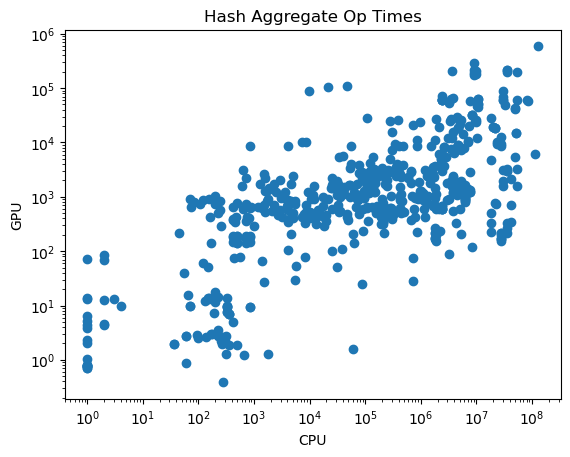

In [39]:
# Create a scatter plot
plt.scatter(cpu_times, gpu_times)
plt.xscale('log')
plt.yscale('log')

# Calculate the linear regression line
# slope, intercept = np.polyfit(cpu_times, gpu_times, 1)
# X = np.array(cpu_times).reshape(-1, 1)
# y = np.array(gpu_times)
# regressor = HuberRegressor()
# regressor.fit(X, y)
# slope = regressor.coef_[0]
# intercept = regressor.intercept_
# print(slope, intercept)
# regression_line = np.array(cpu_times) * slope + intercept

# Plot the linear regression line
# plt.plot(cpu_times, regression_line, color='red')  # you can choose any color you like for the line

# Adding title and labels (optional)
plt.title("Hash Aggregate Op Times")
plt.xlabel("CPU")
plt.ylabel("GPU")

# Show the plot
plt.show()

103 103


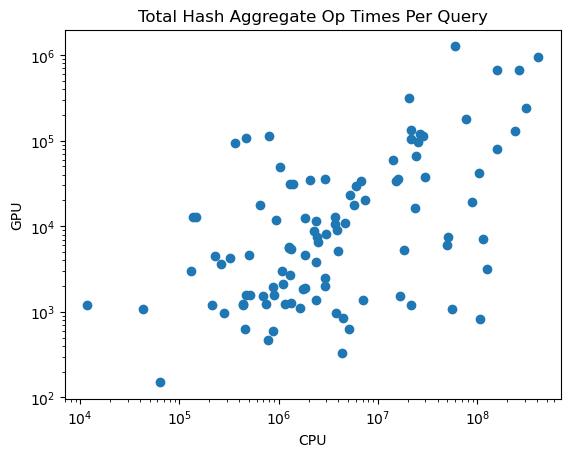

In [40]:
# Create a scatter plot
plt.scatter(cpu_query_times, gpu_query_times)
plt.xscale('log')
plt.yscale('log')
print(len(cpu_query_times), len(gpu_query_times))

# Calculate the linear regression line
# slope, intercept = np.polyfit(cpu_query_times, gpu_query_times, 1)
# print(slope, intercept)
# regression_line = np.array(cpu_query_times) * slope + intercept

# Plot the linear regression line
# plt.plot(cpu_query_times, regression_line, color='red')  # you can choose any color you like for the line

# Adding title and labels (optional)
plt.title("Total Hash Aggregate Op Times Per Query")
plt.xlabel("CPU")
plt.ylabel("GPU")

# Show the plot
plt.show()